**Прогноз времени доставки продуктов интрнет сервисом**

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Загрузка-необходимых-библиотек" data-toc-modified-id="1.-Загрузка-необходимых-библиотек-1">1. Загрузка необходимых библиотек</a></span></li><li><span><a href="#2.-Формирование-базы-данных,-выборка-и-получение-из-неё-датафрейма" data-toc-modified-id="2.-Формирование-базы-данных,-выборка-и-получение-из-неё-датафрейма-2">2. Формирование базы данных, выборка и получение из неё датафрейма</a></span></li><li><span><a href="#3.-Формирование-датафрейма-заказов" data-toc-modified-id="3.-Формирование-датафрейма-заказов-3">3. Формирование датафрейма заказов</a></span></li><li><span><a href="#4.-Формирование-признакового-датасета" data-toc-modified-id="4.-Формирование-признакового-датасета-4">4. Формирование признакового датасета</a></span><ul class="toc-item"><li><span><a href="#4.1.-Выбор-признаков-и-группировка-датасета" data-toc-modified-id="4.1.-Выбор-признаков-и-группировка-датасета-4.1">4.1. Выбор признаков и группировка датасета</a></span></li><li><span><a href="#4.2.-Распределения-в-датасете" data-toc-modified-id="4.2.-Распределения-в-датасете-4.2">4.2. Распределения в датасете</a></span></li></ul></li><li><span><a href="#5.-Оптимизация-кодирования-и-нормализация-признаков-датасета" data-toc-modified-id="5.-Оптимизация-кодирования-и-нормализация-признаков-датасета-5">5. Оптимизация кодирования и нормализация признаков датасета</a></span></li><li><span><a href="#6.-Построение-алгоритмов-прогнозирования" data-toc-modified-id="6.-Построение-алгоритмов-прогнозирования-6">6. Построение алгоритмов прогнозирования</a></span><ul class="toc-item"><li><span><a href="#6.1.-Общие-положения-для-алгоритмов-моделирования" data-toc-modified-id="6.1.-Общие-положения-для-алгоритмов-моделирования-6.1">6.1. Общие положения для алгоритмов моделирования</a></span></li><li><span><a href="#6.2.-Модель-&quot;Линейная-регресия&quot;" data-toc-modified-id="6.2.-Модель-&quot;Линейная-регресия&quot;-6.2">6.2. Модель "Линейная регресия"</a></span></li><li><span><a href="#6.3.-Модель-&quot;Дерево-приня-решения&quot;" data-toc-modified-id="6.3.-Модель-&quot;Дерево-приня-решения&quot;-6.3">6.3. Модель "Дерево приня решения"</a></span></li><li><span><a href="#6.4.-Модель-&quot;Случайный-лес-деревьев&quot;" data-toc-modified-id="6.4.-Модель-&quot;Случайный-лес-деревьев&quot;-6.4">6.4. Модель "Случайный лес деревьев"</a></span></li><li><span><a href="#6.5.-Укрупнение-диапазона-прогноза-дней-поставки" data-toc-modified-id="6.5.-Укрупнение-диапазона-прогноза-дней-поставки-6.5">6.5. Укрупнение диапазона прогноза дней поставки</a></span></li></ul></li></ul></div>

# 1. Загрузка необходимых библиотек

In [1]:
# Импортируем библиотеки
import pandas as pd
import os
import sqlite3
import datetime as dt
import typing as t

from sklearn.impute import SimpleImputer # стратегия заполнения пропусков
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder # кодирование категариальных фичей
from sklearn.preprocessing import StandardScaler, MinMaxScaler # стратегии нормализации значений фичей

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import cross_val_predict # механизм кросс-валидации
from sklearn.metrics import mean_squared_error, roc_auc_score # метрика качества MSE, ROC_AUC

# 2. Формирование базы данных, выборка и получение из неё датафрейма

Из-за большого объёма результата суммарного запроса к удалённой базе данных средства удалённого исполнения запроса "зависают". Для формировании базы локально - база скачена с удалённого сервера таблицами

In [2]:
# Читаем таблицs базы данных из файлов *.csv
data_path = './Data/'
tables = [elem[:-4] for elem in os.listdir(data_path) if elem[-4:] == '.csv']

In [3]:
tables

['customers',
 'products',
 'orders',
 'delivery_info',
 'orders_product',
 'app_sess']

In [4]:
# Создаём локальную базу данных (для экономии времени - без ограничений первичных ключей и типов полей)
connection = sqlite3.connect(f'{data_path}skillbox')
print('База данных подключена\n')
print('Заполнены таблицы:')
for table in tables:
    df = pd.read_csv(f'{data_path}{table}.csv')
    df.to_sql(f'{table}', connection, if_exists='replace', index=False)
    print(f' - {table} {df.shape}, '
          f'дубликатов {len(df[df.duplicated()])}, '
          f'путсых ячеек {df.isnull().sum().sum()};')
cursor = connection.cursor()
connection.close()
print('\nСоединение с базой данных закрыто')

База данных подключена

Заполнены таблицы:
 - customers (500, 7), дубликатов 0, путсых ячеек 0;
 - products (15, 4), дубликатов 0, путсых ячеек 0;
 - orders (2950, 4), дубликатов 0, путсых ячеек 0;
 - delivery_info (3039, 4), дубликатов 0, путсых ячеек 0;
 - orders_product (5990, 3), дубликатов 0, путсых ячеек 0;
 - app_sess (5336, 5), дубликатов 0, путсых ячеек 84;

Соединение с базой данных закрыто


# 3. Формирование датафрейма заказов

In [5]:
# Формируем запрос, объединяющий заказы и совокупное время их доставки
# (убираем данные по заказам, в которых есть хотя бы одна не доставленная позиция)
query_1 = """
            SELECT  o.order_id,
                    o.order_dt,
                    JULIANDAY(d.delivery_dt) - JULIANDAY(o.order_dt) as lead_time_per_day,
                    o.payment_method
            FROM orders o
            INNER JOIN delivery_info d -- выбираем только заказы, на которые были назначены доставки (63% заказов)
                    ON o.order_id = d.order_id
            GROUP BY o.order_id
            HAVING MIN(d.is_completed_flg) == 1 -- выбираем только заказы с полностью завершённой доставкой (24 заказов)
            
        """

In [6]:
# Формируем запрос, объединяющий заказы и продукты
# (убираем данные по заказам, в которых есть хотя бы одна не доставленная позиция)
query_2 = """SELECT  op.order_id,
                     op.product_id,
                     op.amount,
                     p.product_name,
                     p.product_group_name,
                     p.price
            FROM orders_product op
            INNER JOIN products p
                    ON op.product_id = p.product_id"""

In [7]:
# Заполняем датафрейм результатами запроса
connection = sqlite3.connect(f'{data_path}skillbox')
print('База данных подключена')
# Загрузим датасет с заказами и временем доставки
df_1 = pd.read_sql_query(query_1, connection)
df_2 = pd.read_sql_query(query_2, connection)
print('Датафрейм заполнен фичами и параметрами для расчёта целевой переменной')
connection.close()
print('Соединение с базой данных закрыто')

База данных подключена
Датафрейм заполнен фичами и параметрами для расчёта целевой переменной
Соединение с базой данных закрыто


In [8]:
# Объеденим в единый датафрейм: заказы, время их выполенния и сведения о продуктах в заказе
df_3 = df_2.merge(df_1)
df_3['total_price'] = df_3.amount * df_3.price
df_3['payment_method'] = df_3['payment_method'].apply(lambda x: 1 if  x == 'online' else 0)
df_3['day_week_order'] = df_3['order_dt'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').isoweekday())
df_3['day_month_order'] = df_3['order_dt'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').day)
df_3['month_order'] = df_3['order_dt'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').month)
df_3['lead_time_per_day'] = df_3['lead_time_per_day'].astype(int)
df_3

,order_id,product_id,amount,product_name,product_group_name,price,order_dt,lead_time_per_day,payment_method,total_price,day_week_order,day_month_order,month_order
0,56277,2,31,Штаны,Одежда,2100,2020-11-27,27,0,65100,5,27,11
1,56277,8,31,Часы напольные,Часы,500,2020-11-27,27,0,15500,5,27,11
2,56277,14,9,Сок,Напитки,100,2020-11-27,27,0,900,5,27,11
3,56277,5,41,Часы наручные,Часы,1000,2020-11-27,27,0,41000,5,27,11
4,63941,12,18,Круассан,Продукты,50,2021-07-30,8,1,900,5,30,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,71233,15,35,Вода,Напитки,20,2021-07-09,10,1,700,5,9,7
1410,14624,6,8,Часы с кукушкой,Часы,90000,2022-06-27,56,0,720000,1,27,6
1411,75540,3,26,Юбка,Одежда,10000,2022-04-17,58,0,260000,7,17,4
1412,18828,1,12,Носки,Одежда,500,2021-12-10,37,1,6000,5,10,12


# 4. Формирование признакового датасета

## 4.1. Выбор признаков и группировка датасета

**Признаки, которые могут отражать поведенческие патерны связанные с временем исполнения заказа**:  
- метод платежа (поведенческая особенность покупателя, который может определять набор товаров),
- количество групп товаров в заказе (разное время комплектование и/или доставки),
- количество отдельных наименований товаров в заказе (разное время комплектование и/или доставки),
- совокупное количество наименований товаров в заказе (разное время комплектование и/или доставки),
- средняя цена товаров в заказе (разные цены характеризуют разнообразее комплектов товаров в заказе),
- совокупная стоимость заказа (характеризует размер заказа),
- параметры даты заказа: "день недели"/"число месяца"/"месяц года" (характеризуют рабочие дни, загрузку доставки, сезонность).

In [9]:
# Сгруппируем заказы, сформировав их признаки и целевую переменную
df = df_3.groupby('order_id').agg({
                                   'day_week_order': 'max',
                                   'day_month_order': 'max',
                                   'month_order': 'max',
                                   'payment_method': 'max',
                                   'product_group_name': 'nunique',
                                   'product_name': 'nunique',
                                   'amount': 'sum',
                                   'price': 'mean',
                                   'total_price': 'sum',
                                   'lead_time_per_day': 'max'
                                  })
# Переименуем столбцы в более краткие и понятные названия
df.rename(columns={
                   'day_week_order': 'day_week',
                   'day_month_order': 'day_month',
                   'month_order': 'month',
                   'payment_method': 'pay_meth',
                   'product_group_name': 'group_count',
                   'product_name': 'prod_count',
                   'price': 'avg_price',
                  },
          inplace=True)
df

,day_week,day_month,month,pay_meth,group_count,prod_count,amount,avg_price,total_price,lead_time_per_day
order_id,,,,,,,,,,
87,3,26,2,1,1,1,41,15000.000000,615000,60
109,2,13,9,0,2,2,69,510.000000,21960,51
184,7,30,8,1,1,2,77,6050.000000,540900,43
237,6,11,12,0,2,3,60,5023.333333,181380,33
276,7,26,6,1,1,1,47,5.000000,235,5
...,...,...,...,...,...,...,...,...,...,...
97756,7,16,4,0,2,4,88,5150.000000,428000,59
97860,5,3,9,0,3,5,127,3720.000000,272550,24
98129,5,29,10,1,1,1,49,500.000000,24500,32


## 4.2. Распределения в датасете

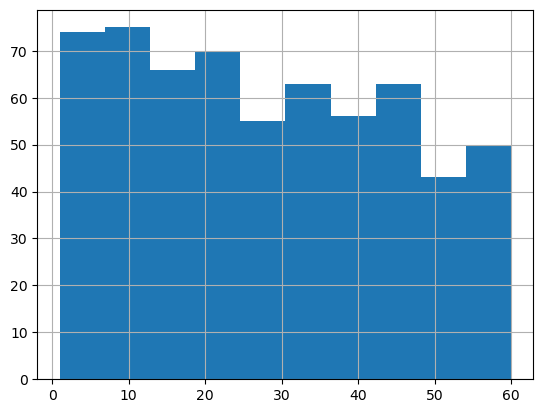

In [10]:
# Распределение таргета датасета (дни доставки заказов)
df.lead_time_per_day.hist();

**Вывод:** В датасете, принятом для обучения - таргет распределён приблизительно равномерно по всем знаячениям с отклонением +-30%.

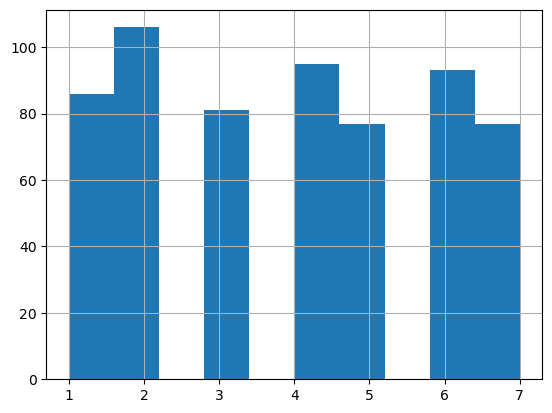

In [11]:
# Распределение дней недели, в которые делается заказ (дни доставки заказов)
df.day_week.hist();

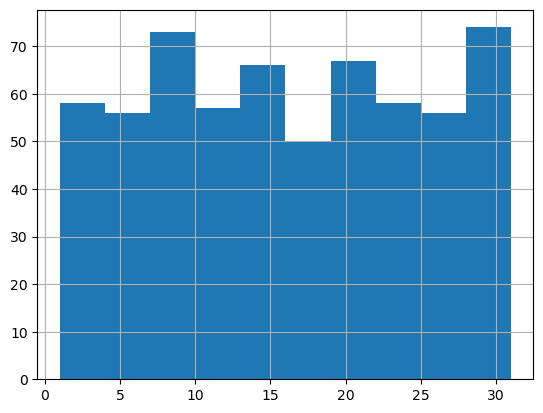

In [12]:
# Распределение дней месяцв, в которые делается заказ (дни доставки заказов)
df.day_month.hist();

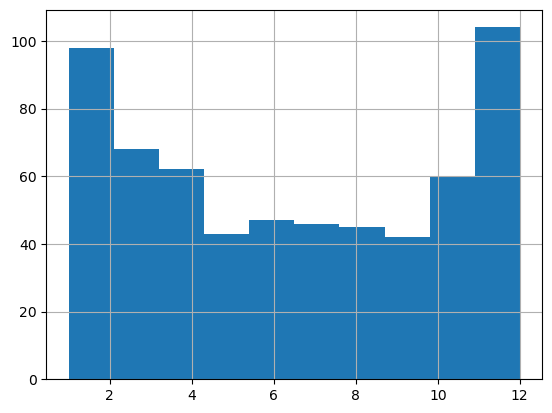

In [13]:
# Распределение дней месяца, в которые делается заказ (дни доставки заказов)
df.month.hist();

**Вывод:** в холодные месяцы года заказы фактически удваются, что свидетельствует о том что покупателям комфортнее делать заказы из дома в холожные периоды.

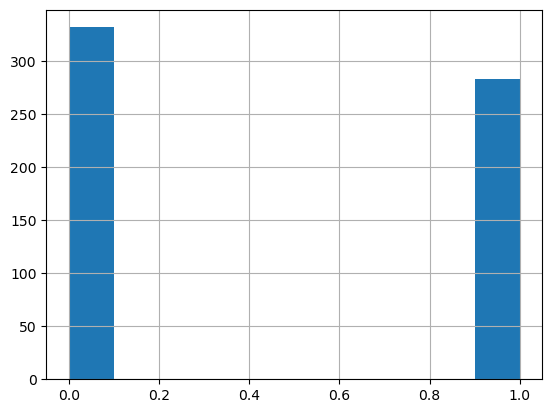

In [14]:
# Распределение методов оплаты заказа
df.pay_meth.hist();

**Вывод:** Покупателей оплачивающих 'online' незначительно меньше, чем оплачивающих 'offline'.

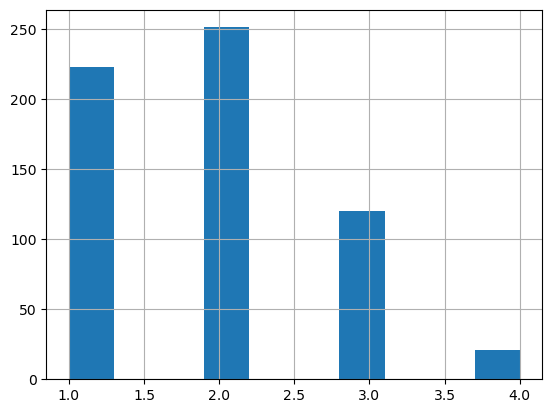

In [15]:
# Распределение количества названий групп товаров в заказе
df.group_count.hist();

**Вывод:** В основном покупатели делают заказы из 2, 1 или 3 групп товаров. Заказы с товарами из более 3 групп явлются редкими.

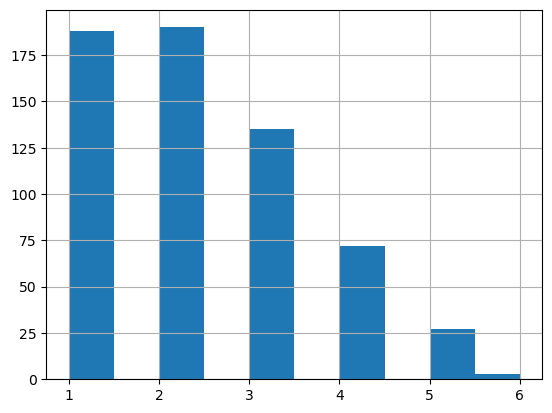

In [16]:
# Распределение количества названий товаров в заказе
df.prod_count.hist();

**Вывод:** В основном покупатели заказывают по 1, 2 или 3 названия товара. Заказы более 5 названий товаров являются редкими.

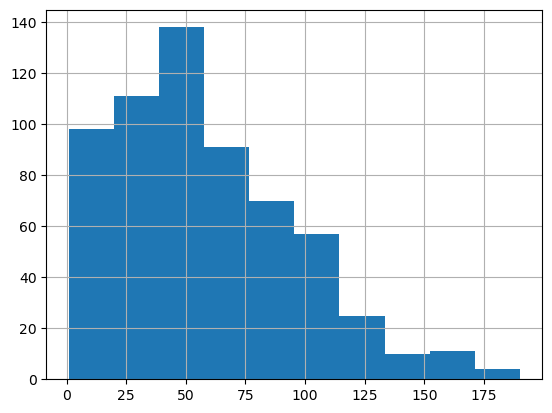

In [17]:
# Распределение количесвта товаров в заказе
df.amount.hist();

**Вывод:** В основном покупатели заказывают около 50 товаров на один заказ. Заказы с колечеством более 140 шт. товаров являются редкими.

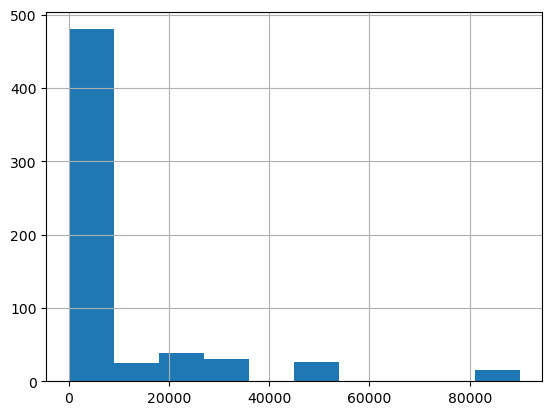

In [18]:
# Распределение средней цены заказа
df.avg_price.hist();

**Вывод**: В основном цена заказа не более 35 тыс. Более дорогие заказы явлются редкими.

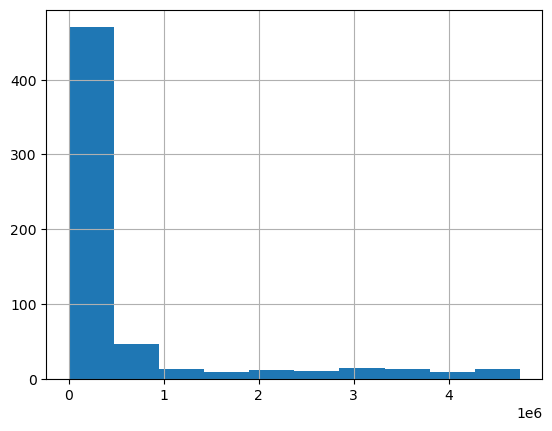

In [19]:
# Распределение полной стоимости заказаов
df.total_price.hist();

**Вывод**: В основном стоимости заказа не превышают 1 млн., более дорогие заказы явлются редкими.

In [20]:
# Исключим из датасета записи со значпниями, которые редкие (то есть выбросами) и могут переобучить модель
df = df[(df.group_count<4) & (df.prod_count<6) & (df.amount<141)
        & (df.avg_price<35000) & (df.total_price<1000000)]
df

,day_week,day_month,month,pay_meth,group_count,prod_count,amount,avg_price,total_price,lead_time_per_day
order_id,,,,,,,,,,
87,3,26,2,1,1,1,41,15000.000000,615000,60
109,2,13,9,0,2,2,69,510.000000,21960,51
184,7,30,8,1,1,2,77,6050.000000,540900,43
237,6,11,12,0,2,3,60,5023.333333,181380,33
276,7,26,6,1,1,1,47,5.000000,235,5
...,...,...,...,...,...,...,...,...,...,...
97368,3,14,4,1,3,3,32,30333.333333,195000,14
97756,7,16,4,0,2,4,88,5150.000000,428000,59
97860,5,3,9,0,3,5,127,3720.000000,272550,24


# 5. Оптимизация кодирования и нормализация признаков датасета

In [21]:
# Количесвто уникальных значений в каждом имеющемся признаке
df.nunique()

day_week               7
day_month             31
month                 12
pay_meth               2
group_count            3
prod_count             5
amount               122
avg_price            155
total_price          409
lead_time_per_day     60
dtype: int64

**Выбранные стратегии дополнительной кодировки признаков и таргета**:
1. Для повышения эффективности точности обучения модели - признаки `group_count` и `prod_count` возмозно закодировать стратегией OneHotEncoder, так как количество уникальных значений у них небольшое;  
2. В связи с большим количесвтом уникальных значений у признаков `day_week`, `day_month`, `month`, `amount`, `avg_price`, `total_price` для экономии вычислительных ресурсов их кодировка стратегией OneHotEncoder не целесообразна. Данные признаки уже факически закодированы по принципу OrdinalEncoder. Для уравнивания влияния данных признаков при обучении проведём их нормализацию;  
3. Признак `pay_meth` кодировать не надо, так как он уже закодирован как бинарный (то есть кодировка максимально эффективна);
4. Целевая переменная `lead_time_per_day` остаётся в формате `int` и в дополнительнорй кодировке не нуждается, так как будет прогнозироваться регрессией.

In [22]:
# Кодируем признаки group_count и prod_count сратегией OneHotEncoder
for col in ['group_count', 'prod_count']:
    ohe = OneHotEncoder(handle_unknown='ignore')
    x_ohe = ohe.fit_transform(df[[col]])
    encoder_df = pd.DataFrame(index= df.index, data=x_ohe.toarray(),
                              columns=[str(col)+'_'+str(elem) for elem in ohe.categories_[0]])
    df = df.join(encoder_df)
    df.drop(columns=[col], axis=1, inplace=True)
df.head(5)

,day_week,day_month,month,pay_meth,amount,avg_price,total_price,lead_time_per_day,group_count_1,group_count_2,group_count_3,prod_count_1,prod_count_2,prod_count_3,prod_count_4,prod_count_5
order_id,,,,,,,,,,,,,,,,
87,3,26,2,1,41,15000.000000,615000,60,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
109,2,13,9,0,69,510.000000,21960,51,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
184,7,30,8,1,77,6050.000000,540900,43,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
237,6,11,12,0,60,5023.333333,181380,33,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
276,7,26,6,1,47,5.000000,235,5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [23]:
# Нормализуем признаки day_week, day_month, month, amount, avg_price, total_price
for col in ['day_week', 'day_month', 'month', 'amount', 'avg_price', 'total_price']:
    mmsc = MinMaxScaler()
    df[col] = mmsc.fit_transform(df[[col]])
df.head(5)

,day_week,day_month,month,pay_meth,amount,avg_price,total_price,lead_time_per_day,group_count_1,group_count_2,group_count_3,prod_count_1,prod_count_2,prod_count_3,prod_count_4,prod_count_5
order_id,,,,,,,,,,,,,,,,
87,0.333333,0.833333,0.090909,1,0.289855,0.445462,0.654947,60,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
109,0.166667,0.400000,0.727273,0,0.492754,0.015002,0.023371,51,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
184,1.000000,0.966667,0.636364,1,0.550725,0.179581,0.576032,43,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
237,0.833333,0.333333,1.000000,0,0.427536,0.149082,0.193150,33,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
276,1.000000,0.833333,0.454545,1,0.333333,0.000000,0.000234,5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# 6. Построение алгоритмов прогнозирования

## 6.1. Общие положения для алгоритмов моделирования

In [24]:
# Функция расчёта метрики ROC AUC
def multipli_roc_auc(y: pd.DataFrame, y_pred: pd.DataFrame) -> t.NoReturn:
    """
    Функция расчётм метрики ROC AUC для мультиклассов в предсказаниях
    Параметры:
        y (DataFrame):      вектор фактических значений целевой переменной
        y_pred (DataFrame): вектор предсказанных значений целевой переменной
    """
    df = pd.DataFrame(data={'y': list(y), 'y_pred': [round(ry) for ry in list(y_pred)]})
    dfs = list()
    for positive in set(y):
        df['y_positive'] = df['y'].apply(lambda x: 1 if x == positive else 0)
        df['y_pred_positive'] = df['y_pred'].apply(lambda x: 1 if x == positive else 0)
        metric = round(roc_auc_score(df['y_positive'], df['y_pred_positive']), 2)
        dfs.append(metric)
    multimetric = round(sum(dfs) / len(dfs), 3)
    print(f'Мульти метрика ROC AUC: {multimetric}')
    print(f'Мульти метрика    Gini: {round(2 * multimetric - 1, 3)}')

In [25]:
# Значения целевой переменной в обучающих данных
print(' '.join([str(elem) for elem in sorted((df.lead_time_per_day.unique()))]))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60


Поскольку:  
1) целевая переменная измеряется непрерывными целыми числами - наиболее целесообразно применять алгоритм прогнозирования "регресссия",  
2) диапазон изменения целевой переменной незначителен - натболее целесообразно выбрать метрику MSE и ROC AUC  

Дополнительно: При получении прогнозов результат работы обученной модели целесообразно округлять до целого числа. Учитывая важность соответсвия `ожиданий клиента` и `прогноза периода доставки заказов` - целесообрахно в продакшене результаты прогноза дней доставки округлять до целого числа вверх.

In [26]:
# Зададим данные для обучения
X = df.drop(['lead_time_per_day'], axis=1)
y = df['lead_time_per_day']

## 6.2. Модель "Линейная регресия"

In [27]:
# Обучим модель "Линейная регресия"
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
print(f'Метрика MSE: {mean_squared_error(y_pred, y, squared=False)}')
# Выведем мульти метрику ROC_AUC
multipli_roc_auc(y, y_pred)

Метрика MSE: 17.040830243576966
Мульти метрика ROC AUC: 0.499
Мульти метрика    Gini: -0.002


In [28]:
# Проверка качества обучения модели кросс-валидацией
y_pred = cross_val_predict(lr, X, y)
print(f'Метрика MSE: {mean_squared_error(y_pred, y, squared=False)}')
# Выведем мульти метрику ROC_AUC
multipli_roc_auc(y, y_pred)

Метрика MSE: 17.575911590780855
Мульти метрика ROC AUC: 0.501
Мульти метрика    Gini: 0.002


**Вывод:** Значнеие ошибки прогнозирования при кроссвалидации значительно не изменилось, значит модель обучена корректно

## 6.3. Модель "Дерево приня решения"

In [29]:
# Обучим модель "Дерево принятия решения"
tr = DecisionTreeRegressor()
tr.fit(X, y)
y_pred = tr.predict(X)
print(f'Метрика MSE: {mean_squared_error(y_pred, y, squared=False)}')
# Выведем мульти метрику ROC_AUC
multipli_roc_auc(y, y_pred)

Метрика MSE: 0.0
Мульти метрика ROC AUC: 1.0
Мульти метрика    Gini: 1.0


**Вывод:** 100% точность предсказаний модели свидетельсвует о переобучении

In [30]:
# Проверка качества обучения модели кросс-валидацией
y_pred = cross_val_predict(tr, X, y)
print(f'Метрика MSE: {mean_squared_error(y_pred, y, squared=False)}')
# Выведем мульти метрику ROC_AUC
multipli_roc_auc(y, y_pred)

Метрика MSE: 24.59221135856091
Мульти метрика ROC AUC: 0.494
Мульти метрика    Gini: -0.012


**Вывод**: Алгоритм склонен к переобучению, так как при кросвалидации появилась ошибка предсказаний, которая полностью отсутсвовала при прогнозировании моделью, обученной на всей выборке. Обучение с неограниченной глубиной дерева при кроссвалижации показывает ошибку предсказаний моделью "Дерево принятия решения" большую чем моделью "Линейная регрессия"

In [31]:
# Ограничим глубину дерева для исклоючения переобучения модели
tr = DecisionTreeRegressor(max_depth=1)
tr.fit(X, y)
y_pred = tr.predict(X)
print(f'Метрика MSE: {mean_squared_error(y_pred, y, squared=False)}')
# Выведем мульти метрику ROC_AUC
multipli_roc_auc(y, y_pred)

Метрика MSE: 17.188195139962236
Мульти метрика ROC AUC: 0.501
Мульти метрика    Gini: 0.002


In [32]:
# Проверка качества обучения модели кросс-валидацией
y_pred = cross_val_predict(tr, X, y)
print(f'Метрика MSE: {mean_squared_error(y_pred, y, squared=False)}')
# Выведем мульти метрику ROC_AUC
multipli_roc_auc(y, y_pred)

Метрика MSE: 17.67235726669406
Мульти метрика ROC AUC: 0.5
Мульти метрика    Gini: 0.0


**Вывод**: Алгоритм "Дерево принятия решений" при ограничении глубины обучается лучше алгоритма "Линейная регрессия"

## 6.4. Модель "Случайный лес деревьев"

In [33]:
# Обучим модель "Дерево принятия решения"
rfr = RandomForestRegressor(max_depth=1)
rfr.fit(X, y)
y_pred = rfr.predict(X)
print(f'Метрика MSE: {mean_squared_error(y_pred, y, squared=False)}')
# Выведем мульти метрику ROC_AUC
multipli_roc_auc(y, y_pred)

Метрика MSE: 17.114894963332098
Мульти метрика ROC AUC: 0.498
Мульти метрика    Gini: -0.004


**Вывод:** точность предсказаний модели очень высокая, что может свидетельсвовать о переобучении

In [34]:
# Проверка качества обучения модели кросс-валидацией
y_pred = cross_val_predict(rfr, X, y)
print(f'Метрика MSE: {mean_squared_error(y_pred, y, squared=False)}')
# Выведем мульти метрику ROC_AUC
multipli_roc_auc(y, y_pred)

Метрика MSE: 17.410919877631994
Мульти метрика ROC AUC: 0.498
Мульти метрика    Gini: -0.004


**Вывод:** Алгоритм "Случайный лес деревьев" при ограничении глубины обучается лучше алгоритма "Дерево принятия решения". При этом низкое значение характеристики ROC AUC показывает что модель предсказывает значения классов или недостаточно точно или неполно.

## 6.5. Укрупнение диапазона прогноза дней поставки

Поскольку среднеквадратичное отклонение показывает ошибку прогноза около 10% от реальных велечин - для повышения качества прогноза с целью снижения недовольства клиентов задержкой доставки относительно прогнозного времени целесообразно укрупнить целевые значния до диапазонов нескольких дней.

In [35]:
# Укрупняем таргет от 1 дня до 5 дней
def day_range(day: int) -> int:
    """
        Функция приведения количества дней доставки к диапазонам количества дней доставки товара
        
        Параметры:
            day (int): количество дней доставки
        Выходные параметры (int)
    """
    dr = 0
    DAY_RNGE = 5
    for ran in range(12):
        if day in range((ran*DAY_RNGE+1), (ran*DAY_RNGE+1)+DAY_RNGE):
            dr = ran+1
            break
    return dr


df['lead_time_per_day'] = df['lead_time_per_day'].apply(lambda x: day_range(x))
df

,day_week,day_month,month,pay_meth,amount,avg_price,total_price,lead_time_per_day,group_count_1,group_count_2,group_count_3,prod_count_1,prod_count_2,prod_count_3,prod_count_4,prod_count_5
order_id,,,,,,,,,,,,,,,,
87,0.333333,0.833333,0.090909,1,0.289855,0.445462,0.654947,12,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
109,0.166667,0.400000,0.727273,0,0.492754,0.015002,0.023371,11,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
184,1.000000,0.966667,0.636364,1,0.550725,0.179581,0.576032,9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
237,0.833333,0.333333,1.000000,0,0.427536,0.149082,0.193150,7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
276,1.000000,0.833333,0.454545,1,0.333333,0.000000,0.000234,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97368,0.333333,0.433333,0.272727,1,0.224638,0.900975,0.207655,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
97756,1.000000,0.500000,0.272727,0,0.630435,0.152844,0.455795,12,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
97860,0.666667,0.066667,0.727273,0,0.913043,0.110363,0.290244,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [36]:
# Зададим обновлённые данные для обучения на датасете с таргетом,
# преобразованным в укрупнённые диапазоны дней доставки
X = df.drop(['lead_time_per_day'], axis=1)
y = df['lead_time_per_day']

In [37]:
# Обучим лучшую модель (Случайный лес)
rfr = RandomForestRegressor()
rfr.fit(X, y)
y_pred = rfr.predict(X)
print(f'Метрика MSE: {mean_squared_error(y_pred, y, squared=False)}')
# Выведем мульти метрику ROC_AUC
multipli_roc_auc(y, y_pred)

Метрика MSE: 1.3708645549795113
Мульти метрика ROC AUC: 0.586
Мульти метрика    Gini: 0.172


In [39]:
# Проверка качества обучения модели кросс-валидацией
y_pred = cross_val_predict(rfr, X, y)
print(f'Метрика MSE: {mean_squared_error(y_pred, y, squared=False)}')
# Выведем мульти метрику ROC_AUC
multipli_roc_auc(y, y_pred)

Метрика MSE: 3.706702355918519
Мульти метрика ROC AUC: 0.503
Мульти метрика    Gini: 0.006


**Вывод:** Укрупнение диапазонов целевой переменной значительно улучшило качество предсказаний, что видно из знаений метрик MSE и ROC AUC